<a href="https://colab.research.google.com/github/SrijaKandese21uari200/INFLUENCER/blob/main/FUELGROWTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless face-recognition numpy pandas pillow requests openpyxl

import cv2
import numpy as np
import pandas as pd
import os
import requests
import tempfile
import face_recognition
from PIL import Image as PILImage
from io import BytesIO
from google.colab import files

# YOLO configuration
cfg_file = '/content/sample_data/yolov3.cfg'
weights_file = '/content/sample_data/yolov3.weights'
coco_names_file = '/content/sample_data/coco.names'

# Load YOLO model
yolo_net = cv2.dnn.readNet(weights_file, cfg_file)
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

with open(coco_names_file, "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Create output directory
output_dir = "extracted_faces"
os.makedirs(output_dir, exist_ok=True)

# Load dataset from Google Sheets
url = "https://docs.google.com/spreadsheets/d/1Bj4-sd6362GWrFZOPcND3fFo0oroO1pfhkpMJh8iIE4/export?format=csv"
data = pd.read_csv(url)

# Ensure 'Performance' is numeric
data['Performance'] = pd.to_numeric(data['Performance'], errors='coerce')
data.dropna(subset=['Performance'], inplace=True)

# Variables for influencer tracking
known_encodings = []
known_ids = []
next_id = 0

# Function to calculate IoU for merging detections
def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union_area = w1 * h1 + w2 * h2 - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Merge overlapping detections
def merge_detections(detections, iou_threshold=0.5):
    merged = []
    for detection in detections:
        if all(iou(detection, d) < iou_threshold for d in merged):
            merged.append(detection)
    return merged

# Assign or retrieve influencer ID
def get_influencer_id(face_image):
    global next_id
    rgb_face = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
    face_encodings = face_recognition.face_encodings(rgb_face)
    if len(face_encodings) > 0:
        face_encoding = face_encodings[0]
        matches = face_recognition.compare_faces(known_encodings, face_encoding, tolerance=0.6)
        if True in matches:
            return known_ids[matches.index(True)]
        else:
            known_encodings.append(face_encoding)
            known_ids.append(next_id)
            next_id += 1
            return next_id - 1
    return None

# Detect faces using YOLO
def detect_faces(frame):
    height, width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    yolo_net.setInput(blob)
    outputs = yolo_net.forward(output_layers)

    detections = []
    for out in outputs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3 and labels[class_id] == 'person':
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = center_x - w // 2
                y = center_y - h // 2
                detections.append((x, y, w, h))
    return merge_detections(detections)

# Extract faces from video
def extract_faces_from_video(video_url, frame_interval=1000):
    influencer_data = []
    response = requests.get(video_url, stream=True)
    if response.status_code != 200:
        print(f"Failed to download video from: {video_url}")
        return influencer_data

    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as tmp_file:
        tmp_file.write(response.content)
        tmp_file_path = tmp_file.name

    cap = cv2.VideoCapture(tmp_file_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_url}")
        return influencer_data

    while True:
        cap.set(cv2.CAP_PROP_POS_MSEC, cap.get(cv2.CAP_PROP_POS_MSEC) + frame_interval)
        success, frame = cap.read()
        if not success:
            break

        detections = detect_faces(frame)
        for (x, y, w, h) in detections:
            if x < 0 or y < 0 or w <= 0 or h <= 0:
                continue

            face_crop = frame[y:y + h, x:x + w]
            if face_crop is None or face_crop.size == 0:
                continue

            influencer_id = get_influencer_id(face_crop)
            if influencer_id is not None:
                face_path = os.path.join(output_dir, f"influencer_{influencer_id}.jpg")
                if cv2.imwrite(face_path, face_crop):
                    influencer_data.append({
                        'Influencer ID': influencer_id,
                        'Video URL': video_url,
                        'Face Image': face_path
                    })

    cap.release()
    return influencer_data

# Process videos
all_influencers = []
for video_url in data['Video URL']:
    influencers = extract_faces_from_video(video_url)
    all_influencers.extend(influencers)

# DataFrame from influencer data
influencer_data_df = pd.DataFrame(all_influencers)

# Calculate average performance per influencer
final_influencer_data = influencer_data_df.groupby('Influencer ID').agg(
    Average_Performance=('Video URL', lambda x: np.mean([data.loc[data['Video URL'] == video_url, 'Performance'].values[0] for video_url in x])),
    Face_Image=('Face Image', 'first')
).reset_index()

# Display influencers
def display_influencer_table(df):
    for _, row in df.iterrows():
        print(f"Influencer ID: {row['Influencer ID']}")
        print(f"Average Performance: {row['Average_Performance']}")
        if os.path.exists(row['Face_Image']):
            img = PILImage.open(row['Face_Image'])
            img.show()

display_influencer_table(final_influencer_data)

# Function to generate influencer HTML table
def generate_influencer_html_table(df, html_output):
    html_content = "<html><body><table border='1'><tr><th>Influencer ID</th><th>Average Performance</th><th>Face Image</th></tr>"
    for _, row in df.iterrows():
        html_content += f"<tr><td>{row['Influencer ID']}</td><td>{row['Average_Performance']}</td><td><img src='{row['Face_Image']}' width='100'></td></tr>"
    html_content += "</table></body></html>"
    with open(html_output, 'w') as f:
        f.write(html_content)

# Function to save influencer data to both Excel and HTML
def save_influencer_data(df, excel_output='influencer_data.xlsx', html_output='influencer_table.html'):
    # Save to Excel
    df.to_excel(excel_output, index=False, engine='openpyxl')
    print(f"Excel file saved as {excel_output}")

    # Save to HTML
    generate_influencer_html_table(df, html_output)
    print(f"HTML table saved as {html_output}")

    # Optionally, provide a download link for Excel
    download_excel(excel_output)


# Function to download Excel file
def download_excel(file_name):
    files.download(file_name)

# Example usage to save both files
save_influencer_data(final_influencer_data)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=20b6cd798d69d4136bd071922efc30c0770b45d59a6e7257fc4f5f5a8917c8cf
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
Influencer ID: 0
Average Performance: 1.0890788197581445
Influencer ID: 1
Average Performance: 1.004369870753333
Influencer ID: 2
Average Performance: 1.1842831092666666
Influencer ID: 3
Average Performance: 0.8911125932966217
Influencer ID: 4
Average Performance: 0.9244997303135595
Influencer ID: 5
Average Performance: 0.7735539946350001
Influencer ID: 6
Average Performance: 0.5864596602307691
Influencer ID: 7
Average Performance: 0.7427007758222222
Influencer ID: 8
Average Performance: 1.169607244342857
Influencer ID: 9
Average

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Excel file saved as influencer_data.xlsx
HTML table saved as influencer_table.html
HTML table saved as influencer_table.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Influencer ID: 0
Average Performance: 1.0890788197581445
Displaying image from extracted_faces/influencer_0.jpg


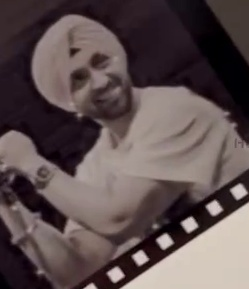

Influencer ID: 1
Average Performance: 1.004369870753333
Displaying image from extracted_faces/influencer_1.jpg


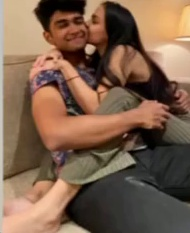

Influencer ID: 2
Average Performance: 1.1842831092666666
Displaying image from extracted_faces/influencer_2.jpg


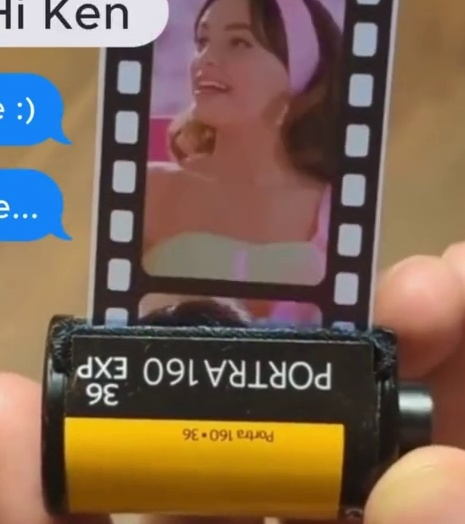

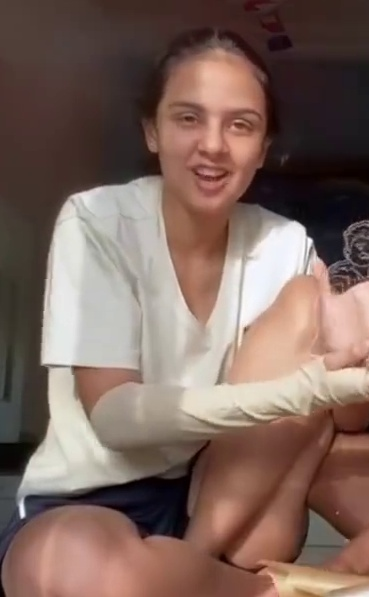

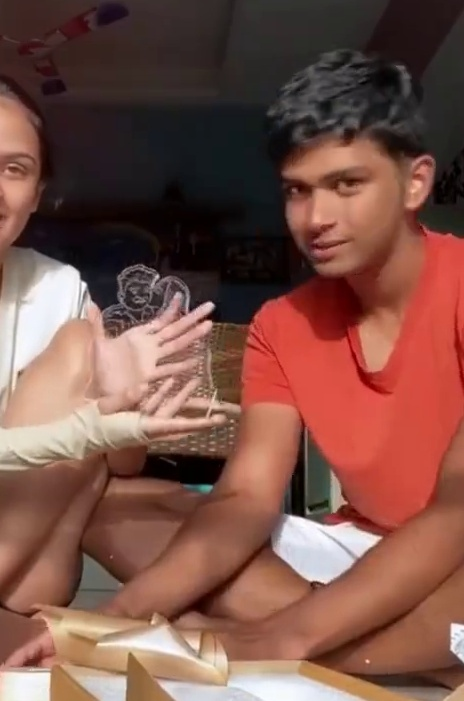

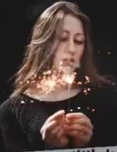

Influencer ID: 3
Average Performance: 0.8911125932966217
Displaying image from extracted_faces/influencer_3.jpg
Influencer ID: 4
Average Performance: 0.9244997303135595
Displaying image from extracted_faces/influencer_4.jpg
Influencer ID: 5
Average Performance: 0.7735539946350001
Displaying image from extracted_faces/influencer_5.jpg
Influencer ID: 6
Average Performance: 0.5864596602307691
Displaying image from extracted_faces/influencer_6.jpg


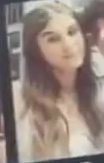

Influencer ID: 7
Average Performance: 0.7427007758222222
Displaying image from extracted_faces/influencer_7.jpg


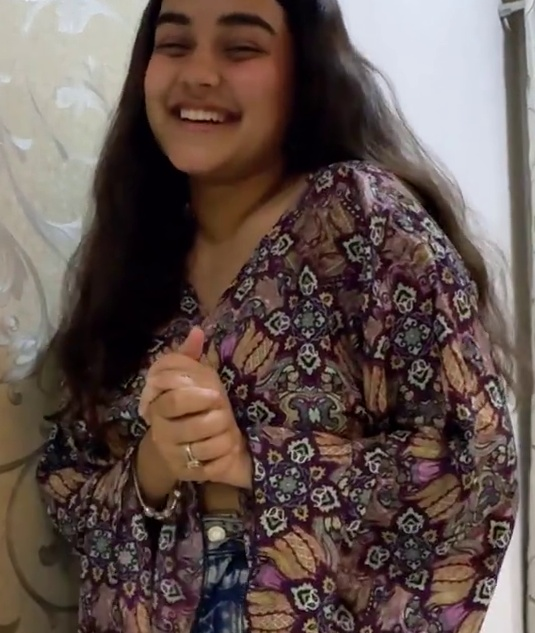

Influencer ID: 8
Average Performance: 1.169607244342857
Displaying image from extracted_faces/influencer_8.jpg


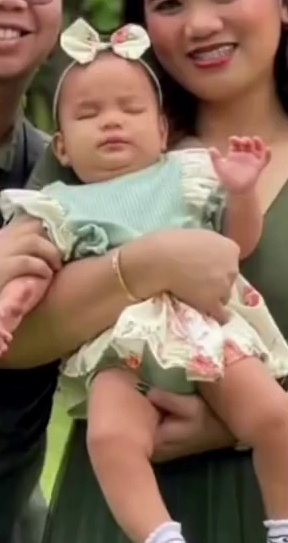

Influencer ID: 9
Average Performance: 0.8356160320076923
Displaying image from extracted_faces/influencer_9.jpg


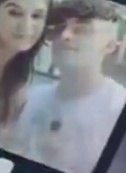

Influencer ID: 10
Average Performance: 1.64080986556
Displaying image from extracted_faces/influencer_10.jpg


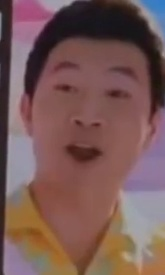

Influencer ID: 11
Average Performance: 0.48819719271000006
Displaying image from extracted_faces/influencer_11.jpg


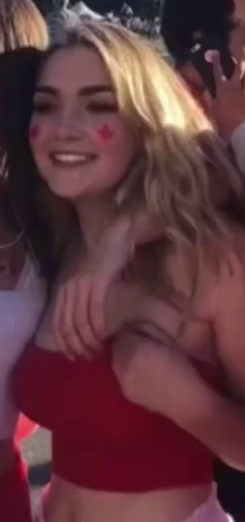

Influencer ID: 12
Average Performance: 0.7569200770499999
Displaying image from extracted_faces/influencer_12.jpg


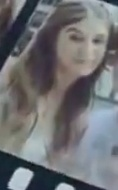

Influencer ID: 13
Average Performance: 0.3950387393
Displaying image from extracted_faces/influencer_13.jpg


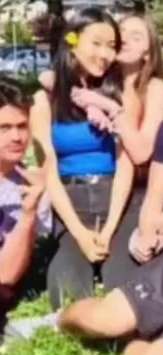

Influencer ID: 14
Average Performance: 1.1076218445888888
Displaying image from extracted_faces/influencer_14.jpg


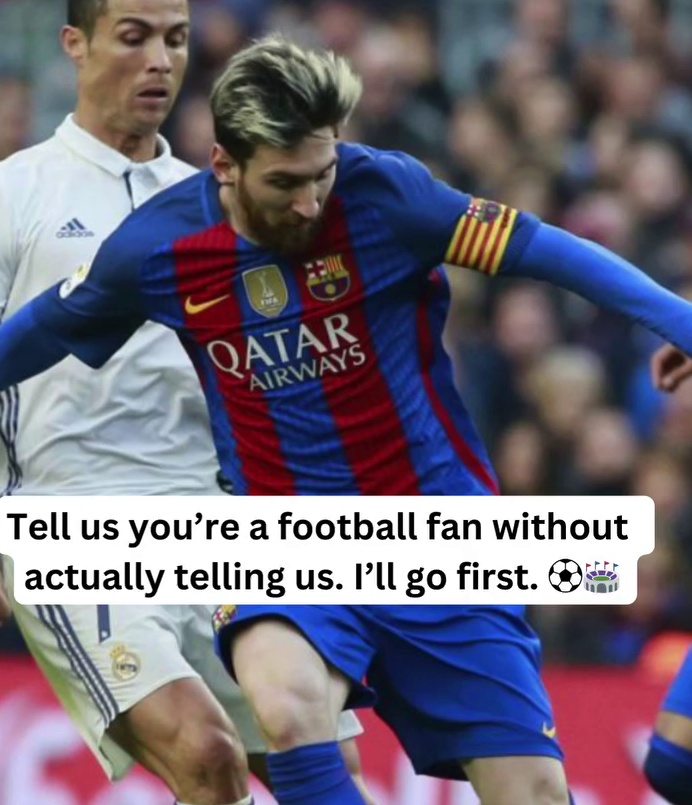

Influencer ID: 15
Average Performance: 0.6825525958
Displaying image from extracted_faces/influencer_15.jpg


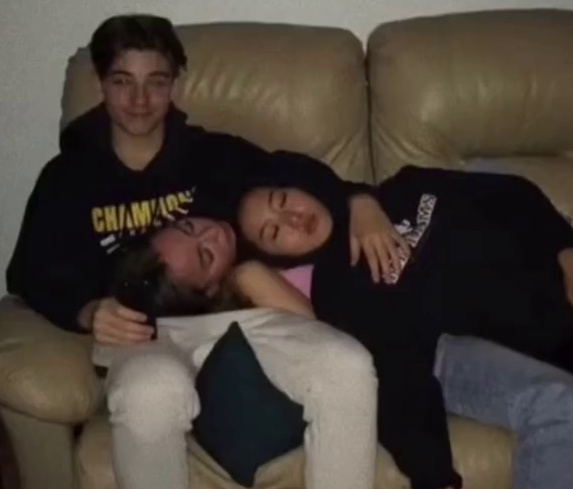

Influencer ID: 16
Average Performance: 0.7593534753257143
Displaying image from extracted_faces/influencer_16.jpg


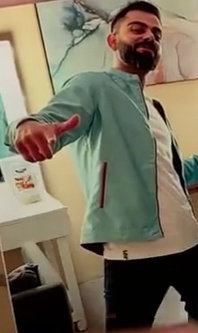

Influencer ID: 17
Average Performance: 0.3103
Displaying image from extracted_faces/influencer_17.jpg


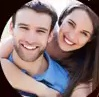

Influencer ID: 18
Average Performance: 0.3103
Displaying image from extracted_faces/influencer_18.jpg


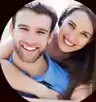

Influencer ID: 19
Average Performance: 0.61552119255
Displaying image from extracted_faces/influencer_19.jpg


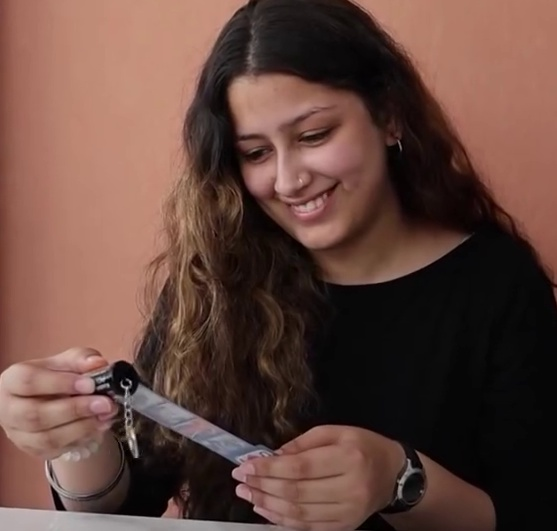

Influencer ID: 20
Average Performance: 0.5874243650689656
Displaying image from extracted_faces/influencer_20.jpg


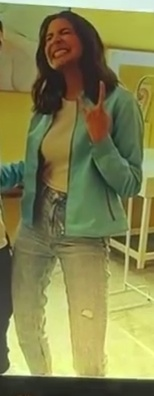

Influencer ID: 21
Average Performance: 0.7345797254999998
Displaying image from extracted_faces/influencer_21.jpg


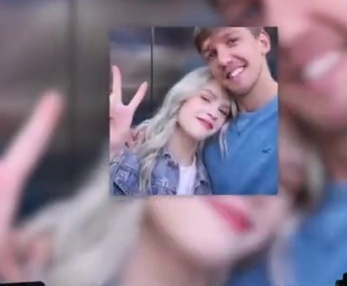

Influencer ID: 22
Average Performance: 0.7345797255
Displaying image from extracted_faces/influencer_22.jpg


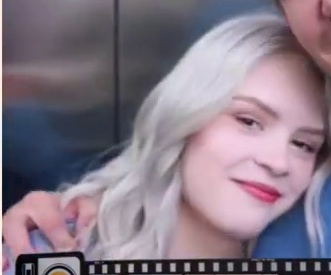

Influencer ID: 23
Average Performance: 0.826
Displaying image from extracted_faces/influencer_23.jpg


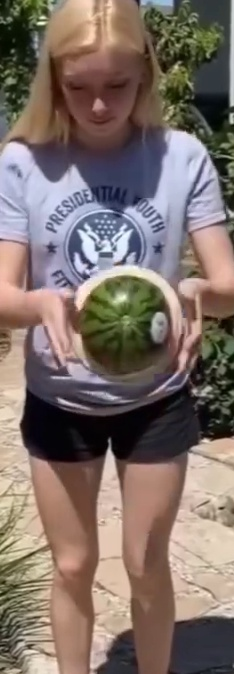

Influencer ID: 24
Average Performance: 0.6357150876000001
Displaying image from extracted_faces/influencer_24.jpg


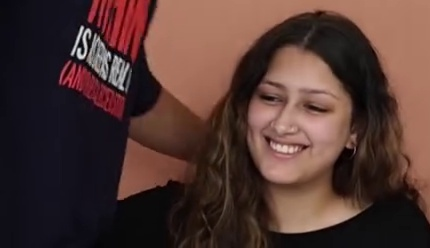

Influencer ID: 25
Average Performance: 0.8046488051
Displaying image from extracted_faces/influencer_25.jpg


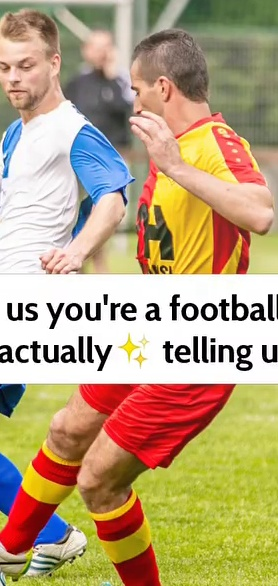

Influencer ID: 26
Average Performance: 0.2263771565
Displaying image from extracted_faces/influencer_26.jpg


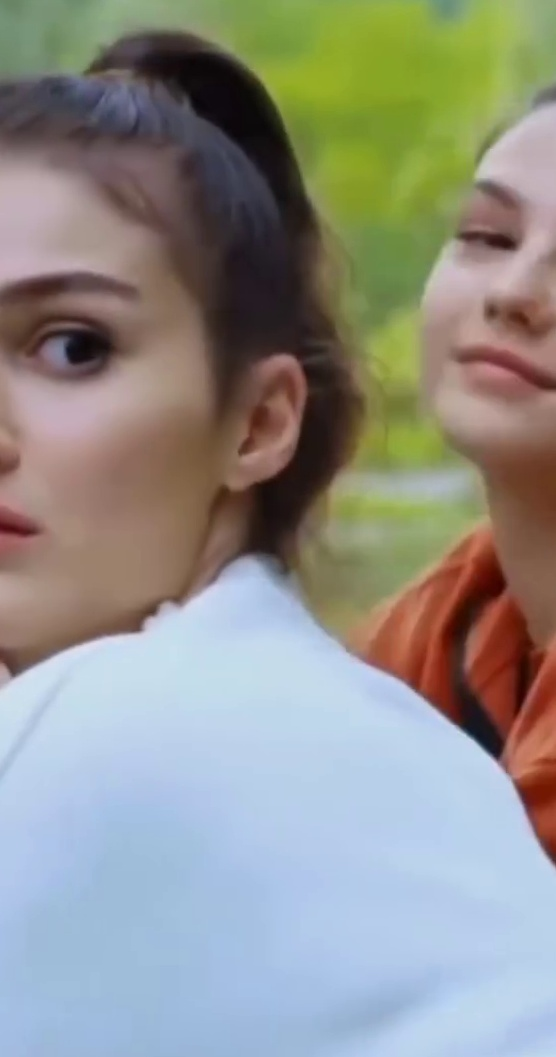

Influencer ID: 27
Average Performance: 1.13626387636
Displaying image from extracted_faces/influencer_27.jpg


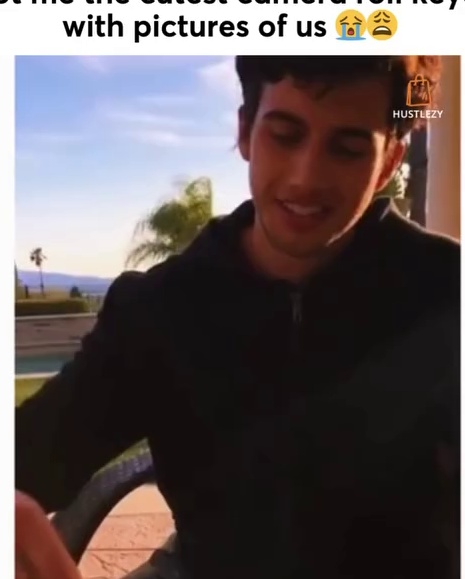

Influencer ID: 28
Average Performance: 1.1202488492
Displaying image from extracted_faces/influencer_28.jpg


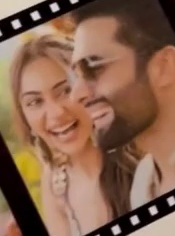

Influencer ID: 29
Average Performance: 0.2043241062
Displaying image from extracted_faces/influencer_29.jpg


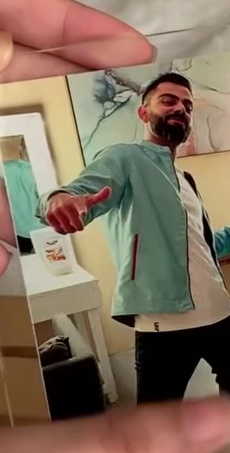

Influencer ID: 30
Average Performance: 0.84060569968
Displaying image from extracted_faces/influencer_30.jpg


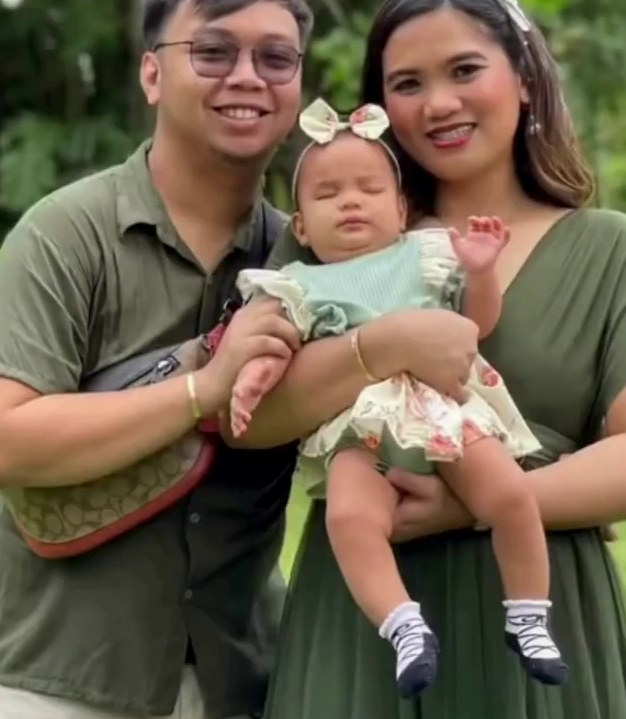

Influencer ID: 31
Average Performance: 0.7770419316
Displaying image from extracted_faces/influencer_31.jpg


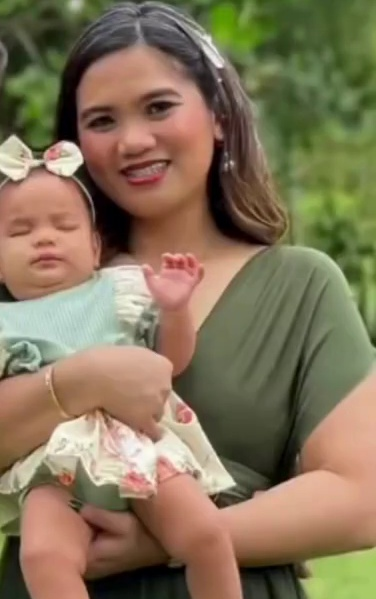

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from PIL import Image as PILImage
from google.colab import files
from IPython.display import Image as IPImage, display  # For inline image display

# Directory to save face images
output_dir = "/content/extracted_faces"
os.makedirs(output_dir, exist_ok=True)


# Display images inline in Colab output
def display_influencer_table(df):
    for _, row in df.iterrows():
        print(f"Influencer ID: {row['Influencer ID']}")
        print(f"Average Performance: {row['Average_Performance']}")

        # Check if image exists in the extracted_faces directory
        image_path = row['Face_Image']

        if os.path.exists(image_path):
            print(f"Displaying image from {image_path}")
            img = PILImage.open(image_path)
            display(IPImage(image_path))  # Display image inline in Colab
        else:
            print(f"Image not found for Influencer ID: {row['Influencer ID']} at {image_path}")

# Example usage to save both files and display images inline
display_influencer_table(final_influencer_data)


In [ ]:
# Display images inline in Colab output
def display_influencer_table(df):
    # Sort the dataframe by Average_Performance in descending order
    df_sorted = df.sort_values(by='Average_Performance', ascending=False)

    for _, row in df_sorted.iterrows():
        print(f"Influencer ID: {row['Influencer ID']}")
        print(f"Average Performance: {row['Average_Performance']}")

        # Check if image exists in the extracted_faces directory
        image_path = row['Face_Image']

        if os.path.exists(image_path):
            print(f"Displaying image from {image_path}")
            img = PILImage.open(image_path)
            display(IPImage(image_path))  # Display image inline in Colab
        else:
            print(f"Image not found for Influencer ID: {row['Influencer ID']} at {image_path}")

# Example usage to save both files and display images inline
save_influencer_data(final_influencer_data)
display_influencer_table(final_influencer_data)


In [ ]:
# Function to calculate metrics for consistency and performance
def calculate_influencer_metrics(influencer_data_df, video_data):
    # Group by Influencer ID and calculate metrics
    influencer_stats = influencer_data_df.groupby('Influencer ID').agg(
        Average_Performance=('Video URL', lambda x: np.mean([video_data.loc[video_data['Video URL'] == url, 'Performance'].values[0] for url in x])),
        Performance_StdDev=('Video URL', lambda x: np.std([video_data.loc[video_data['Video URL'] == url, 'Performance'].values[0] for url in x])),
        Face_Image=('Face Image', 'first')
    ).reset_index()

    # Calculate Consistency Score
    influencer_stats['Consistency_Score'] = influencer_stats['Average_Performance'] / (influencer_stats['Performance_StdDev'] + 1)

    # Add Performance Category
    influencer_stats['Performance_Category'] = pd.cut(
        influencer_stats['Consistency_Score'],
        bins=[-float('inf'), 2, 5, 10, float('inf')],
        labels=['Low Performer', 'Stable Performer', 'Top Performer', 'Exceptional Performer']
    )

    return influencer_stats

# Calculate metrics
final_influencer_data = calculate_influencer_metrics(influencer_data_df, data)

# Display influencers with new metrics
def display_influencer_metrics_table(df):
    sorted_df = df.sort_values(by='Consistency_Score', ascending=False)
    for _, row in sorted_df.iterrows():
        print(f"Influencer ID: {row['Influencer ID']}")
        print(f"Average Performance: {row['Average_Performance']:.2f}")
        print(f"Performance StdDev: {row['Performance_StdDev']:.2f}")
        print(f"Consistency Score: {row['Consistency_Score']:.2f}")
        print(f"Performance Category: {row['Performance_Category']}")
        if os.path.exists(row['Face_Image']):
            img = PILImage.open(row['Face_Image'])
            img.show()

display_influencer_metrics_table(final_influencer_data)